--- IMAGE CLASSIFICATION ---

From dogs and cats => breeds

In [2]:
from fastai.vision.data import untar_data, URLs

# With an unfamiliar dataset, we have to :
# 1. Figure how is it put together
# 2. How to extract the data we need from it
# 3. What the data looks like .i.e. how is it structured with respect to labels
# https://www.robots.ox.ac.uk/~vgg/data/pets/https://www.robots.ox.ac.uk/~vgg/data/pets/
path = untar_data(URLs.PETS)

# open /Users/mton/.fastai/data/ launches an explorer for us to inspect the file
# and folder structure of the dataset
# Looks like list.txt contains the labels for the images for :
# #ID: 1:37 Class ids
# #SPECIES: 1:Cat 2:Dog
# #BREED ID: 1-25:Cat 1:12:Dog
# All images with the first letter as capital are cat images
# All images with the first letter as small are dog images
path.ls() # type: ignore

(#3) [Path('/Users/mton/.fastai/data/oxford-iiit-pet/.DS_Store'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/images'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/annotations')]

In [3]:
# We care about WHAT the pets are, not WHERE the images are
# We are doing image classification, not image localization so we will ignore
# the annotations directory for now
# And instead look at the images directory
# @audit-ok ☑ : Explain what is image localization
# ANSWER : Image localization is the task of finding the LOCATION of an object 
# in an image : a sub-task of object detection
(path/'images').ls() # type: ignore

(#7393) [Path('/Users/mton/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_167.jpg'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/images/pug_52.jpg'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/images/basset_hound_112.jpg'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/images/Siamese_193.jpg'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/images/shiba_inu_122.jpg'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/images/Siamese_53.jpg'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/images/Birman_167.jpg'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/images/leonberger_6.jpg'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/images/Siamese_47.jpg'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/images/shiba_inu_136.jpg')...]

--- REGEX FILE PATH => NAME ---

In [4]:
from fastai.vision.core import re

fname = (path/'images').ls()[0] # type: ignore
print(f'fname[0] : {fname}')
# This regular expression plucks all characters until the last underscore
# as long as the subsequent characters are digits followed by '.jpg' extension
regexName = re.findall(r'(.+)_\d+.jpg$', fname.name) # type: ignore
print(f'regexName : {regexName}')

fname[0] : /Users/mton/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_167.jpg
regexName : ['Egyptian_Mau']


--- DATABLOCK : CROP AND SPLIT ---

In [17]:
from fastai.vision.data import DataBlock, CategoryBlock, ImageBlock, get_image_files, RandomSplitter, RegexLabeller
from fastai.vision.augment import aug_transforms, Resize
from fastai.vision.core import using_attr

pets = DataBlock(
    # config blocks to categorize (PIL) images
    # @note 🧠 : when CategoryBlock is the dependent variable, it's single label
    # and fastai will default to using CrossEntropyLoss
    blocks = (ImageBlock, CategoryBlock), # type: ignore
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    # Construct a function which applies `f` to the argument's attribute `attr`
    # - Applies the regex to the image file name
    # - Egyptian_Mau_167.jpg => Egyptian_Mau
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
    # @note 🧠 : Presizing images to 460x460 pixels before augmentation because:
    # - Upscaling to larger dimensions so that transform and crop ops don't
    #   include empty corners to confuse model, and yield better pixel 
    #   interpolation i.e. large images have margins to crop and lose less data
    # - Compose all augmentation in one GPU pass as opposed to performing 
    #   individual ops with interpolation at each step 
    #   (reduces image degradation)
    item_tfms=Resize(460), # type: ignore
    # @note 🧠 : On TRAINING set uniform window cropping (224 * 244) is performed 
    # RANDOMLY, as opposed to VALIDATION set where it's CENTER cropped
    # Augmentation is performed on TRAINING set only, not VALIDATION set
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
    )

dls=pets.dataloaders(path/'images')

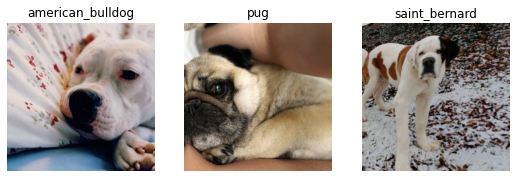

In [18]:
dls.show_batch(nrows=1, ncols=3)

In [19]:
# To debug mistakes while building your DataBlock, use the 'summary' method
# to log the output and narrow down the problem
pets.summary(path/'images') # type: ignore

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /Users/mton/.fastai/data/oxford-iiit-pet/images/saint_bernard_60.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=375x500
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /Users/mton/.fastai/data/oxford-iiit-pet/images/saint_bernard_60.jpg
    applying partial gives
      saint_bernard
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(30)

Final sample: (PILImage mode=RGB size=375x500, TensorCategory(30))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}


--- DEBUG : SUMMARY EXAMPLE ---

In [12]:
# An example that FAILS because we FORGET to resize the images, and as a result
# end up with images of DIFFERENT sizes and we can NOT BATCH them
pets1 = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # type: ignore
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
)


In [13]:
# Summary can help us DEBUG this problem where we FORGET to resize the images :
'''
...
Collating items in a batch
Error! It's not possible to collate your items in a batch
Could not collate the 0-th members of your tuples because got the following shapes
torch.Size([3, 500, 375]),torch.Size([3, 333, 500]),torch.Size([3, 352, 500]),torch.Size([3, 500, 354])
'''
# @note : This CELL will FAIL by design 
pets1.summary(path/'images') # type: ignore

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /Users/mton/.fastai/data/oxford-iiit-pet/images/saint_bernard_60.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=375x500
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /Users/mton/.fastai/data/oxford-iiit-pet/images/saint_bernard_60.jpg
    applying partial gives
      saint_bernard
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(30)

Final sample: (PILImage mode=RGB size=375x500, TensorCategory(30))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}


RuntimeError: Error when trying to collate the data into batches with fa_collate, at least two tensors in the batch are not the same size.

Mismatch found on axis 0 of the batch and is of type `TensorImage`:
	Item at index 0 has shape: torch.Size([3, 500, 375])
	Item at index 1 has shape: torch.Size([3, 333, 500])

Please include a transform in `after_item` that ensures all data of type TensorImage is the same size

--- LEARNERS [X] IMAGE [Y] CATEGORY ---

Generally it's recommmended to start trainging as SOON as possible, 
as soon as our DATA is set up :
 - independent (x, images) and dependent (y, labels) are setup correctly
 - loss function verified
 - augmented for batching

In [22]:
# @audit-issue ❌ : fastai.vision.learner FAILS, use fastai.vision.all instead
# to fastai.vision.learner
from fastai.vision.all import vision_learner, error_rate
from fastai.vision.models import resnet34

# @audit-ok 🔎 : Explain metrics=error_rate
# fastai library includes a metric called error_rate that is used to measure 
# the accuracy of a model. This metric is a combination of accuracy and 
# error rate and is calculated by taking the average of true positives, 
# false negatives, false positives, and true negatives. The error rate metric 
# is used to compare the accuracy of different models and measure how well 
# they perform on a given dataset
# I still don't FULLY understand and can't INTERNALIZE this concept yet LOL
learn = vision_learner(dls, arch=resnet34, metrics=error_rate)
# Loss is whatever function we are using to train the parameters of our model
# We haven't chosen a loss function here, so what is fastai using for loss
# @note 🧠 fastai uses a default function based on the DATA and MODEL we are using
# In this case we have IMAGE data and CATEGORICAL outcomes, so fastai will use
# Cross Entropy Loss by default
# @note ⚠️ : learn.fine_tune ~ 25 minutes
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.489305,0.300345,0.101489,13:34
1,0.319007,0.250195,0.074425,13:26


--- LOSS FUNCTION [CROSS ENTROPY] ---

Cross Entropy Loss are a good DEFAULT :
 1) When our DEPENDENT variable output are from > 2 CATEGORIES ...
 2) But the output is only ONE label ...
 3) Use [BINARY Cross Entropy] (next chapter) for when OUTPUT can be MULTI-label

In [76]:
# Let's step through and to see what's happening under the hood for a batch 
# with cross entropy by VIEWING our ACTIVATION and LABELS

# one_batch() returns a REAL batch of data from DataLoader as mini-batches :
# @note 🧠 [x] = TensorImage torch.Size([3, 224, 224])
# @note 🧠 [y] = TensorCategory torch.Size([64]]) with integer bewtween 0 and 36
#       to categorize the 37 possible pet breeds
x,y = dls.one_batch()
# @audit-ok ☑ : Explain howcome one_batch() returns batch size of 64
# ANSWER : A batch size of 64 is a good size to use when training 
# a neural network, as it allows the network to take advantage of 
# - parallelization and process the data quickly 
# - Additionally, the batch size of 64 is large enough that the model can learn 
#   from the data and small enough that it is not too computationally expensive 
#   to process the data
print(f'--- [x] is independent variable => [TensorImage]    shape [{x[0].shape}] --- \n')
print(f'--- [y] is dependent   variable => [TensorCategory] shape [{y.shape}] --- \n\n{y}')

--- [x] is independent variable => [TensorImage]    shape [torch.Size([3, 224, 224])] --- 

--- [y] is dependent   variable => [TensorCategory] shape [torch.Size([64])] --- 

TensorCategory([26,  3,  1, 29,  8, 14, 13, 13, 15, 11, 32, 20,  3, 22, 31, 28,
                28,  8, 31, 27, 33, 21, 13, 36, 28, 20,  3,  2, 22, 26, 18, 30,
                 0,  1,  3, 32, 12,  3,  5,  5, 30, 27, 21, 21, 12, 31, 28, 27,
                15, 18,  6,  7, 16, 32,  7, 17,  1, 19, 24, 10, 32,  3,  7,  4])


In [77]:
# @audit-issue ❌ : WHY IS THIS NOT LOGGING?? (divided into ^ cell as workaround)
print("Why AM I NOT LOGGING HERE????")
# view predictions (activations of the final layer of our neural network)
# get_preds() takes in an iterator of batches or dataset index (0 = train, 1=valid)
# and returns a tuple of predictions and targets
# - we are feeding in a single batch of data
# - we already have targets, so we ignore the 2nd return value by assigning it 
#   to the special variable._
# @note 🧠 [preds] = TensorBase => [torch.Size([37])] for 37 possible pet breeds
# @audit-ok 🔎 : Explain TensorBase and how it relates to TensorImage and TensorCategory
# TensorBase is a base class for tensors in the torch library. It is the 
# parent class for tensors such as TensorImage and TensorCategory, which are 
# specific tensor types used to store images and categories. TensorBase 
# provides basic methods, such as getitem, len and repr, which are used to 
# access, query and display the data stored in the tensors. As such, 
# TensorBase forms the foundation for the other tensor types, and is essential 
# for working with images and categories in the torch library
# @note ⚠️ : learn.get_preds() ~ 3.3 seconds
preds,_ = learn.get_preds(dl=[(x,y)]) # type: ignore
print(f'---[predictions] TensorBase shape => [{preds[0].shape}]---\n\n{preds[0]}\n')
# The actual predictions are 37 probabilities that sum to 1.0f
print(f'# verify that predictions length [{len(preds[0])}] sum to 1.0f => [{preds[0].sum()}]')

---[predictions] TensorBase shape => [torch.Size([37])]---

TensorBase([2.6677e-07, 4.9440e-07, 4.5094e-08, 8.4627e-07, 9.9369e-08,
            1.1365e-07, 1.9111e-09, 3.4583e-08, 1.6918e-08, 1.8144e-06,
            6.6939e-07, 5.2592e-08, 8.3388e-08, 1.8312e-04, 2.3053e-05,
            1.5483e-06, 3.9228e-04, 8.9721e-05, 4.7637e-05, 2.9412e-07,
            3.1984e-07, 8.9358e-08, 2.6279e-07, 2.9253e-08, 2.3936e-06,
            1.6982e-06, 9.9910e-01, 3.4370e-08, 2.5460e-07, 2.0432e-07,
            1.9605e-08, 7.8100e-08, 7.2664e-07, 1.1920e-05, 1.3204e-04,
            3.6134e-07, 3.9145e-06])

# verify that predictions length [37] sum to 1.0f => [1.0000001192092896]


--- FINAL LAYER ACTIVATION [SOFTMAX] ---


Softmax good ACTIVATION function in the FINAL layer of a CLASSIFCATION model 

because they ensure that the activations are all :

- between 0 and 1
- they sum up to 1



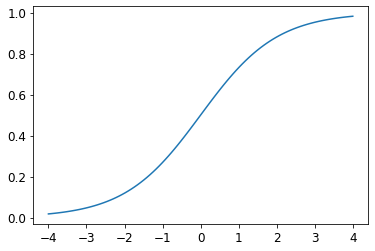

In [78]:
from fastai.vision.core import torch
from fastbook import plot_function

# Softmax is similar to sigmoid, here's a reminder of what sigmoid looks like
# Sigmoid when applied to a single column of activations, we will get a column
# of values between 0 and 1
# But if we have MORE categories in our target (37 pet breeds in this case),
# @note 🧠 : we need an ACITVATION per CATEGORY as oppposed to Sigmoid's per COLUMN
plot_function(torch.sigmoid, min=-4, max=4)

In [84]:
# So we need something MORE than SIGMOID
# Let's start with a simpler 2 category (3s and 7s) example (as opposed to the 
# 37 breeds) to better understand what's going on
# A good first step towards creating the more GENERAL approach :

# For this toy example we assume 6 images and 2 categories : 3s and 7s
acts = torch.randn((6,2))*2 # multiply by 2 = standard deviation of 2 
# random numbers with a standard deviation of 2
# @audit-ok ☑ : Explain why we are using a standard deviation of 2 to generate 
# random numbers
# ANSWER : The standard deviation of 2 is used when generating random numbers 
# to ensure that the data is spread out and not clustered in one area. 
# By using a standard deviation of 2, it allows for more randomness in the 
# generated numbers and prevents any patterns from forming. This is important 
# for ensuring that the generated data is useful and accurate. Additionally, 
# a standard deviation of 2 also helps to ensure that the data follows the 
# normal distribution and that the generated numbers are distributed in a more 
# natural and expected way.
acts

tensor([[ 2.2206, -3.3796],
        [-1.9779,  1.9159],
        [ 2.6443,  1.6344],
        [-1.5317, -1.5012],
        [ 2.7051,  1.3726],
        [-0.6555,  1.5899]])

In [86]:
# We want the probability of being a 3 plus the probability of being a 7 to add
# up to 1.0f ... @audit 🛑 ... is this true?
# @note 🧠 : applying SIGMOID directly does NOT add up to 1.0f, this doesn't work
acts.sigmoid()

tensor([[0.9021, 0.0329],
        [0.1215, 0.8717],
        [0.9337, 0.8368],
        [0.1777, 0.1822],
        [0.9373, 0.7978],
        [0.3417, 0.8306]])

In [184]:
# Hmmmm so somehow we went from 2 columns to 1 column ... what is happening LoL
# - Somehow we want to reframe binary problems to serve as a more general classifier
# to handle an arbitrary number of categories
# So what does the value of a pair of activations represent?
# - A single pair of activations simply indicate the relative difference 
#   confidence whether the input is a 3 or a 7
# - The larger the difference, the more confident we are that the input is a 3
# - The smaller the difference, the more confident we are that the input is a 7
# - So the overall value does NOT MATTER, whether they SUM to be HIGH or LOW
# - What MATTERS is the RELATIVE DIFFERENCE between the two values : WHICH is 
#   HIGHER and BY HOW MUCH

# @audit 🖶 -- [3] [7] [SUM] [SIGMOID] [ROW]
print(f'{(acts[:,0]-acts[:,1]).sigmoid()}\n')
print('    [3]       [7]       [SUM]   [SIGMOID]    [ROW]')
print('-------   -------      ------   ---------    ----- ')
current_row = 0
for row in acts:
    sum_row = row[0] - row[1]
    print(f'[{row[0]:5.2f}] - [{row[1]:5.2f}]  =   {sum_row:5.2f}     [{sum_row.sigmoid():5.3f}]      [{current_row}]\n')
    current_row += 1


tensor([0.9963, 0.0200, 0.7330, 0.4924, 0.7912, 0.0957])

    [3]       [7]       [SUM]   [SIGMOID]    [ROW]
-------   -------      ------   ---------    ----- 
[ 2.22] - [-3.38]  =    5.60     [0.996]      [0]

[-1.98] - [ 1.92]  =   -3.89     [0.020]      [1]

[ 2.64] - [ 1.63]  =    1.01     [0.733]      [2]

[-1.53] - [-1.50]  =   -0.03     [0.492]      [3]

[ 2.71] - [ 1.37]  =    1.33     [0.791]      [4]

[-0.66] - [ 1.59]  =   -2.25     [0.096]      [5]



In [ ]:
# softmax is the multi-category equivalent of sigmoid
# use it whenever we have more than 2 categories and the probability of each
# category should sum to 1.0f
# NOTE : often used even when there's only 2 categories for consistency lol
# Intuitively the softmax function REALLY wants to pick one class among the 
# others, given exponential AMPLIFIES any slight relative differences
def softmax(x):
    # exp = exponential function
    # defined as e**x, where is is approximately 2.718
    # this is the inverse of the natural logarithm function 
    # exp is always positive and increases VERY rapidly
    return exp(x)/exp(x).sum(dim=1, keepdim=True) # type: ignore

In [ ]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6108, 0.3892],
        [0.8209, 0.1791],
        [0.2400, 0.7600],
        [0.1862, 0.8138],
        [0.1882, 0.8118],
        [0.4369, 0.5631]])

In [ ]:
from fastai.vision.data import tensor

# Cross Entropy Loss :
# - softmax is the first part
# - log likelihood is the second part

# Log Likelihood
targ = tensor([0,1,0,1,1,0])
idx = range(6)

# We are picking the loss from the column containing the correct label
# And implicitly since all the columns sum to 1.0f because of softmax,
# when we push the activation for the correct label as HIGH as possible
# we are also decreasing the activations for the remaining columns
# This works for binary/2-catagories (3,7) but scales to N categories (0-9)
# TODO : The book formats the numbers as a table nicely ... figure out how to do
# that in Jupyter here
sm_acts[idx, targ]

tensor([0.6108, 0.1791, 0.2400, 0.8138, 0.8118, 0.4369])

In [ ]:
from fastai.vision.data import F

# nll_loss (negative log likelihood loss) : built-in pytorch function equivalent
# assumes log are ALREADY applied, DESPITE having LOG in the name lol
builtin_tensor = F.nll_loss(sm_acts, targ, reduction='none')

# nll_loss applies the log afterwards, so the output values will be negative
manual_tensor = -sm_acts[idx, targ]
print(f'{manual_tensor} # manual tensor \n{builtin_tensor} # builtin tensor')

tensor([-0.6108, -0.1791, -0.2400, -0.8138, -0.8118, -0.4369]) # manual tensor 
tensor([-0.6108, -0.1791, -0.2400, -0.8138, -0.8118, -0.4369]) # builtin tensor


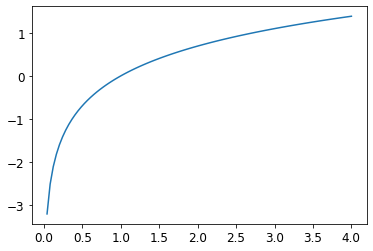

In [ ]:
plot_function(torch.log, min=0, max=4)

In [ ]:
from fastai.vision.core import nn

# Cross Entropy Loss is when we :
# 1) Apply softmax to activations
# 2) And then apply log likelihood to the softmax output

# In pytorch this is available as an nn.CrossEntropyLoss() function
loss_func = nn.CrossEntropyLoss()

# By default pytorch loss function takes the means of the loss of all items
loss_func(acts, targ)

# But we can use reduction='none' to disable that
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.4930, 1.7196, 1.4270, 0.2060, 0.2085, 0.8281])

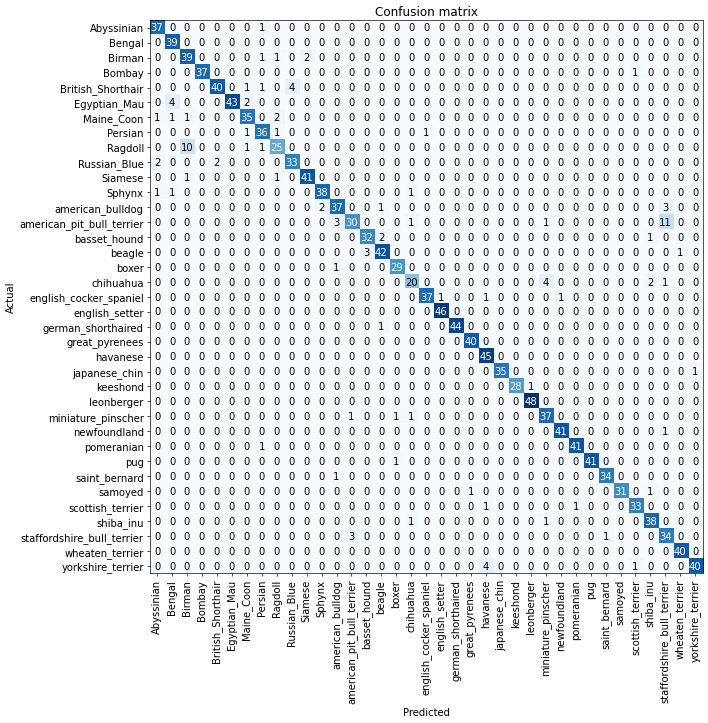

In [ ]:
from fastai.vision.learner import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=5)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 11),
 ('Ragdoll', 'Birman', 10)]

In [ ]:
learn = vision_learner(dls, arch=resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,2.782029,5.888840,0.504736,12:33


epoch,train_loss,valid_loss,error_rate,time
0,3.817205,2.487199,0.637348,17:21


ValueError: not enough values to unpack (expected 2, got 1)

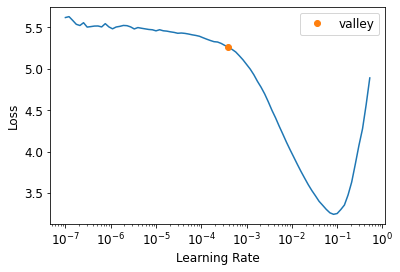

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.lr_find()

In [ ]:
learn.fine_tune??
print(f'Minimum/10: {lr_min:2e}, steepest point: {lr_steep:2e}')

NameError: name 'lr_min' is not defined

Signature:
learn.fine_tune(
    epochs,
    base_lr=0.002,
    freeze_epochs=1,
    lr_mult=100,
    pct_start=0.3,
    div=5.0,
    *,
    lr_max=None,
    div_final=100000.0,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
    start_epoch=0,
)
Source:   
@patch
@delegates(Learner.fit_one_cycle)
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `Learner.freeze` for `freeze_epochs`, then with `Learner.unfreeze` for `epochs`, using discriminative LR."
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
File:      ~/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/fastai/callback/schedule.py
Type:      method


In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.255808,0.334094,0.107578,11:33


epoch,train_loss,valid_loss,error_rate,time
0,0.570410,0.362575,0.108931,14:45
1,0.326410,0.236334,0.073072,16:36


In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.100243,0.357722,0.122463,11:50
1,0.538660,0.288522,0.089310,19:29
2,0.329256,0.228263,0.070365,17:39


In [ ]:
learn.unfreeze()

SuggestedLRs(valley=3.0199516913853586e-05)

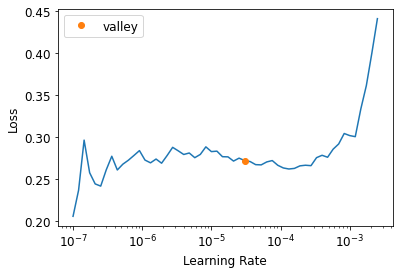

In [ ]:
# Because we have weights that are already trained, and more layers to train
# the model has changed enough where we need to check our learning rate again
# Likely we will need to use a lower learning rate
learn.lr_find()

In [ ]:
learn.lr_find??

Signature:
learn.lr_find(
    start_lr=1e-07,
    end_lr=10,
    num_it=100,
    stop_div=True,
    show_plot=True,
    suggest_funcs=<function valley at 0x169dc98b0>,
)
Source:   
@patch
def lr_find(self:Learner, start_lr=1e-7, end_lr=10, num_it=100, stop_div=True, show_plot=True, suggest_funcs=(SuggestionMethod.Valley)):
    "Launch a mock training to find a good learning rate and return suggestions based on `suggest_funcs` as a named tuple"
    n_epoch = num_it//len(self.dls.train) + 1
    cb=LRFinder(start_lr=start_lr, end_lr=end_lr, num_it=num_it, stop_div=stop_div)
    with self.no_logging(): self.fit(n_epoch, cbs=cb)
    if suggest_funcs is not None:
        lrs, losses = tensor(self.recorder.lrs[num_it//10:-5]), tensor(self.recorder.losses[num_it//10:-5])
        nan_idxs = torch.nonzero(torch.isnan(losses.view(-1)))
        if len(nan_idxs) > 0:
            drop_idx = min(nan_idxs)
            lrs = lrs[:drop_idx]
            losses = losses[:drop_idx]
        _suggestions, nm

In [ ]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,2.807385,2.346710,0.627876,13:42
1,2.761513,2.855053,0.615020,13:27
2,2.694891,14.671639,0.604195,12:44
3,2.572668,2.296487,0.590663,12:32
4,2.584789,2.583465,0.594723,12:34
5,2.585968,3.252128,0.591340,12:36


In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6, 1e-4))

/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.180836,0.345385,0.101489,10:44
1,0.534204,0.252715,0.080514,10:21
2,0.331744,0.219855,0.068336,10:17


epoch,train_loss,valid_loss,error_rate,time
0,0.265986,0.212265,0.066982,12:54
1,0.256798,0.206923,0.069012,13:18
2,0.238853,0.205375,0.067659,13:00
3,0.229449,0.199506,0.065629,12:52
4,0.200070,0.194700,0.057510,12:55
5,0.181759,0.196889,0.064953,12:54
6,0.148528,0.188072,0.055480,12:54
7,0.157825,0.187674,0.055480,12:35
8,0.137463,0.188838,0.056834,12:36
9,0.139100,0.188969,0.058187,12:51


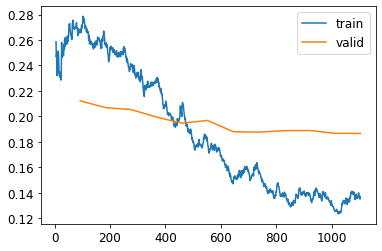

In [ ]:
learn.recorder.plot_loss()

In [ ]:
from fastai.callback.fp16 import *
from fastai.vision.models import resnet50
learn = vision_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,error_rate,time
0,1.286211,0.266255,0.083221,23:56
1,0.594020,0.288783,0.093369,23:34
2,0.402422,0.294151,0.089986,24:51


epoch,train_loss,valid_loss,error_rate,time
0,0.270663,0.213406,0.072395,32:03
1,0.310084,0.337039,0.106901,26:31
2,0.263010,0.259290,0.080514,26:37
3,0.145033,0.202008,0.054804,30:54
4,0.088044,0.181623,0.048038,32:03
5,0.057410,0.178267,0.047361,27:09
